# Identifying Quasars in SDSS Stripe 82 Data

AST502 Final Presentation, 12/06/2017

Allie Hughes, Ryan Keenan, Erin Maier, Lukas Wenzl

In [1]:
# import the python modules 
import numpy as np
import tables 
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
from astropy.coordinates import SkyCoord
from astropy import units 
from astropy.coordinates import match_coordinates_sky
from astroquery.vizier import Vizier
from astroquery.irsa import Irsa

# Introduction

- Quasars are extremely luminous active galactice nuclei (AGN)
- They emit light across the electromagnetic spectrum and can be observed in most wavelength bands
- The name "quasar" comes from "quasi-stellar radio source": they were first identified as radio emission sources which appeared as dim star-like point sources in optical wavelengths
- Quasars are readily confirmed by spectroscopic observations, but how can we identify a candidate quasar in the first place?
- Most known quasars come from time domain observations (SDSS)
- Quasars typically possess interesting properties in the time domain in their color and variability which can be used to nominally identify them


## BIG QUESTIONS: 

## What filters can we construct for quasar properties in order to identify quasars?
## How completely and efficiently do these filters identify known quasars?

# Data

- Archival SDSS data from Stripe 82 : 300 $deg^{2}$ of sky coverage from 20h to 4h RA and -1.26 - +1.26 deg declination. We used   data from RA 0 to 1h.


<img src='stripe82_footprint.jpg'>
(Abazajian et al 2009)


- Specifically used the LMCC (Light-Motion-Curve Catalog) (Bramich et al 2008)

     - Contains light curves for ~4 million objects in Stripe 82 in ugriz filters
     - Coverage from 24h - 3.3h RA and -1.26 to +1.26 deg declinations (249 $deg^{2}$)
     
     
- 2MASS Extended Source Catalog, to check that our candidates are not an extended source
- XMM-Newton X-ray source catalog, to check for associated x-ray sources
- Data Release 7 (DR7) Quasar Catalog, for result validation (Schneider et al 2010)

In our subsample we had 348,329 objects. 1094 of them are listed in the SDSS Quasar Catalog. For demonstration purposes, we constructed a sample of 15 objects (11 quasars, 4 non-quasars).

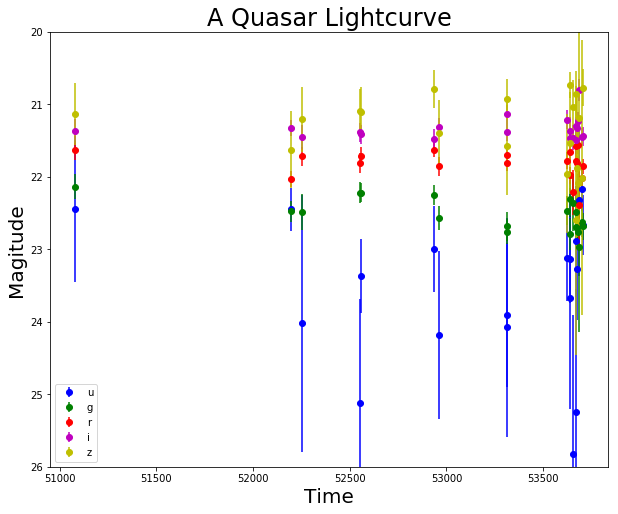

In [2]:
# Get lightcurve

path = "get_Data/" 
filename ='RA_00_to_01/00/lc_00_00_06.502_-01_02_46.059_t'#one of the sample quasars
data = np.genfromtxt(path+filename, comments="#")

           #mag, err mag, time
u = data[:, [11,12,10]][np.where(data[:,4]==0)].T
g = data[:, [11,12,10]][np.where(data[:,4]==1)].T
r = data[:, [11,12,10]][np.where(data[:,4]==2)].T
i = data[:, [11,12,10]][np.where(data[:,4]==3)].T
z = data[:, [11,12,10]][np.where(data[:,4]==4)].T

passbands=['u', 'g', 'r', 'i', 'z']

plt.figure(figsize=(10,8))
plt.ylim(20,26)

plt.errorbar(u[2],u[0], yerr=u[1], linestyle="", marker="o", label="u", color='b')
plt.errorbar(g[2],g[0], yerr=g[1], linestyle="", marker="o", label="g", color='g')
plt.errorbar(r[2],r[0], yerr=r[1], linestyle="", marker="o", label="r", color='r')
plt.errorbar(i[2],i[0], yerr=i[1], linestyle="", marker="o", label="i", color='m')
plt.errorbar(z[2],z[0], yerr=z[1], linestyle="", marker="o", label="z", color='y')
plt.xlabel("Time", fontsize=20)
plt.ylabel("Magitude", fontsize=20)
plt.gca().invert_yaxis()
plt.legend(loc=("lower left"))
plt.title("A Quasar Lightcurve", fontsize=24)
plt.show()

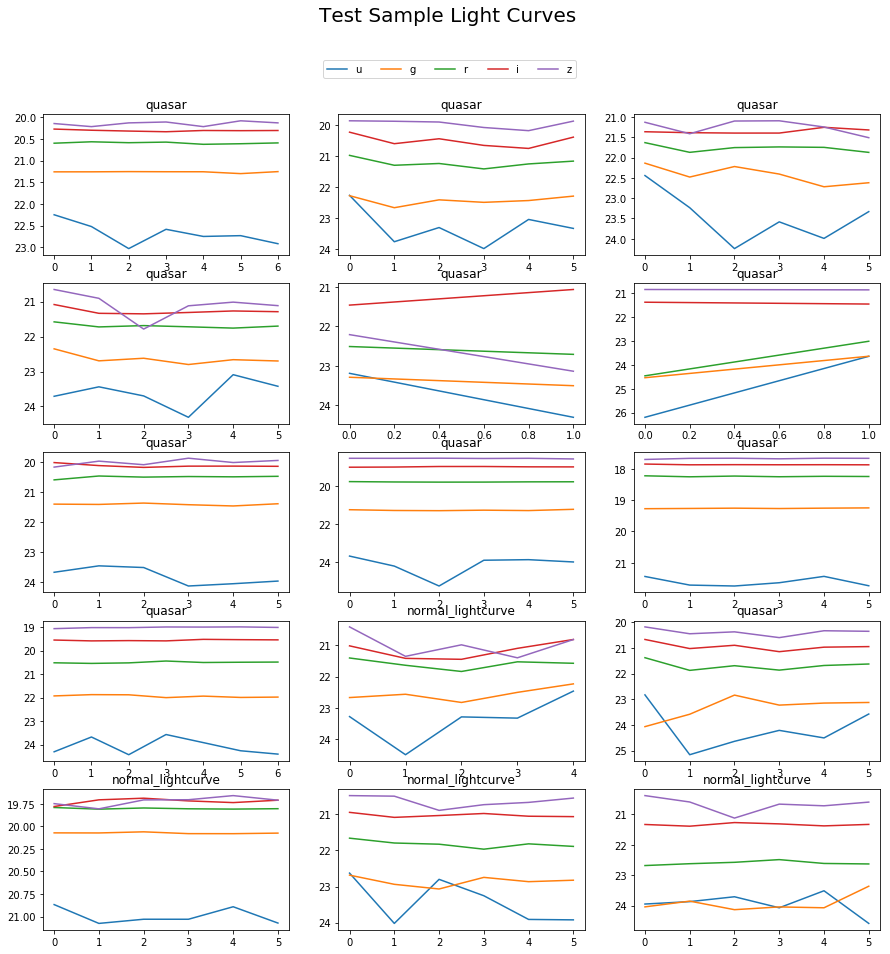

In [11]:
files = np.loadtxt(path + 'small_data_sample.txt', dtype='string', skiprows=1)
def split_years(time, data):
    data_split = [[data[0]]]
    for y in np.arange(0, len(time) - 1):
        if time[y+1] - time[y] > 250:
            data_split.append([])
            data_split[-1].append(data[y+1])
        else:
            data_split[-1].append(data[y+1])
    return data_split

fig, ax = plt.subplots(5, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

for k in range(len(files)):
    filename = path + files[k][0]
    data = np.genfromtxt(filename, comments="#")
    u = data[:, [11,12,10]][np.where(data[:,4]==0)].T; u_split = split_years(u[2], u[0])
    g = data[:, [11,12,10]][np.where(data[:,4]==1)].T; g_split = split_years(g[2], g[0])
    r = data[:, [11,12,10]][np.where(data[:,4]==2)].T; r_split = split_years(r[2], r[0])
    i = data[:, [11,12,10]][np.where(data[:,4]==3)].T; i_split = split_years(i[2], i[0])
    z = data[:, [11,12,10]][np.where(data[:,4]==4)].T; z_split = split_years(z[2], z[0])
    
    u_mean = np.asarray([np.mean(np.asarray(u_split[s])) for s in np.arange(len(u_split))])
    g_mean = np.asarray([np.mean(np.asarray(g_split[s])) for s in np.arange(len(g_split))]) 
    r_mean = np.asarray([np.mean(np.asarray(r_split[s])) for s in np.arange(len(r_split))]) 
    i_mean = np.asarray([np.mean(np.asarray(i_split[s])) for s in np.arange(len(i_split))])
    z_mean = np.asarray([np.mean(np.asarray(z_split[s])) for s in np.arange(len(z_split))])

    ax[int(np.floor(k/3)), (k % 3) - 1].plot(np.arange(len(u_mean)), u_mean, label='u')
    ax[int(np.floor(k/3)), (k % 3) - 1].plot(np.arange(len(g_mean)), g_mean, label='g')
    ax[int(np.floor(k/3)), (k % 3) - 1].plot(np.arange(len(r_mean)), r_mean, label='r')
    ax[int(np.floor(k/3)), (k % 3) - 1].plot(np.arange(len(i_mean)), i_mean, label='i')
    ax[int(np.floor(k/3)), (k % 3) - 1].plot(np.arange(len(z_mean)), z_mean, label='z')
    ax[int(np.floor(k/3)), (k % 3) - 1].set_title(files[k][1])
    ax[int(np.floor(k/3)), (k % 3) - 1].invert_yaxis()
    
    plt.legend(loc='best')    
    plt.suptitle('Test Sample Light Curves', fontsize=20)

plt.legend(bbox_to_anchor=(-.75, 6.2), loc='upper center', ncol=5, borderaxespad=0.2)
plt.show()


## Magnitude distribution of datasample:
![mag histrogram](images/mag_historgram_of_dataset.png)

# Filter 1: X-ray Crossmatching

We crossmatched the SDSS Quasar Calalog with the XMM-Newton Catalog and found only 27 matches. The reason for that is that X-ray coverage of Stripe 82 is **very bad**. Only a small fraction is covered, so it is not a reliable indicator, but if one of our objects is associated with an X-ray source it is a very strong indicator. This method will work better in the future when there is more X-ray data available. Stripe 82X is a current survey working on this.

<img src='stripe82xray.jpg'>
(LaMassa et al 2013)

Sloan Digital Sky Survey Stripe 82 XMM-Newton Source Match Catalog, can be found here
https://heasarc.gsfc.nasa.gov/W3Browse/xmm-newton/sdsss82xmm.html

There are 638 x-ray sources in our subsample area.

![x-ray sources](images/xmm_x-ray_sources.png)

The positions do not line up perfectly. We decided to flag everything within a radius of 1' (arcmin) from an x-ray source and do a second flag for 0.2' = 12".  

![x-ray sources_detail](images/xmm_x-ray_sources_detail.png)

# Filter 2: Quasar Structure Function

Source: Kawaguchi et al. 1998
http://iopscience.iop.org/article/10.1086/306105/pdf 

For a time series of optical magnitude $m_{opt}(t_i), \  i=1,2,\ldots, \  i < j$, the first order structure function is defined as 

$$ V(\tau) = \frac{1}{N(\tau)} \sum_{i < j} [m_{opt}(t_i) - m_{opt}(t_j) ]^2.$$

Summation is made over all pairs $(i,j)$ for which $t_j - t_i = \tau$, and $N(\tau) $ denotes the number of such pairs.

The typical shape of a structure function consist of three distinct parts.  First, there is a plateau at time lags longer than the longest correlation timescale, with a value of twice the variance of the fluctuations.  Second, there is another plateau at short time lags, with a value corresponding to twice the variance of the measurement noise.  Finally, the intermediate part between the two plateaus exhibits a power-law increase with increasing time lag:

$$ [V(\tau)]^{1/2} \propto \tau^\beta.$$

The logarithmic slope $\beta$ depends on the nature of the intrinsic variation of the source (e.g. shot noise, flicker noise, and so on). 

Below is an example light curve and structure function of a quasar that was monitored for about two years.  $[V(\tau)]^{1/2}$ is calculated by averaging the structure functions of image A and B for each time lag $\tau$.  The structure function shows a slope of $\beta \sim 0.35$ at $2 \leq \tau \leq 500$ days.  

<img src="ex_struct_fct.png">

Process:
1. Co-add all the measurements for each band for each year of measurements.  Some years will not have any measurements. (This is the most tedious bit.)
2. Calculate the structure function for each measurent band.
3. Calculate the slope for each structure.
4. Flag the object as not a quasar if there is a general negative trend of the structure function slopes.  Specifically, if there are only one or zero slopes that are positive or if the sum of the slopes (excepting u-band) is negative. 

Co-added measurements for the above lightcurve, with vertical lines denoting the separations between years:

<img src='my_avgs.png'>

Structure function for the above lightcurve:

<img src="my_struct_fct.png">

Structure function for a non-quasar object (likely a star) on the same scale:

<img src="my_obj_ex.png">

Difficulties that arose:
- some quasars were only measured one or two times or were not measured regularly
- there is a maximum of eight data points available to create the structure function with
- some not-quasar objects have deceptive looking structure functions, especially their u-band data

# Filter 3: Color Cutoffs

We followed the procedure used by Richards et al. 2002 to use various cuts in color space to identify objects likely to be quasars. This algorithm was used to select quasars for follow on spectroscopy in SDSS.

First we define a stellar locus - a region of color space that will contain most normal stars.

<img src='color_locus.png'>

Then we add additional color cuts to exclude regions dominated by other non-quasar objects - white dwarfs, A stars, binary systems, etc.

A quick test returns 
- correctly identified quasar
- false negative
- correctly identified quasar
- correctly identified quasar
- not a quasar - correctly rejected
- false positive
- not a quasar - correctly rejected
- false positive

<img src='color_test.png'>

# Filter 4: Extended Source

- Quasars are "quasi-stellar objects" - point sources
- Check the 2MASS extended source catalog in a 1 arcmin radius around each source to ensure we're not looking at an extended source
- Time constraints prevented this from being used on the full dataset of 300,000+ sources, but we did run it on all objects flagged as quasars by the DR7 QSO catalog


In [3]:
files = np.loadtxt(path + '/small_data_sample.txt', dtype='string', skiprows=1)
pos = []

for k in range(len(files)):
    filename = files[k][0]
    data = np.genfromtxt(path + filename, comments="#")
    ra = data[:, 6]
    dec = data[:, 7]
    pos.append((np.mean(ra), np.mean(dec)))
    
flags = []

def search_2MASS(position):
    if position[1] < 0:
        table = Irsa.query_region(SkyCoord(position[0], position[1], unit=(units.deg,units.deg)),
                          catalog='ext_src_cat1', radius='0d2m0s') # query 2MASS XSC for declination < 0
    else:
        table = Irsa.query_region(SkyCoord(position[0], position[1], unit=(units.deg,units.deg)),
                          catalog='ext_src_cat', radius='0d2m0s') # query 2MASS XSC for declination >= 0
    
    if len(table) == 0:
        flags.append(1)
        return 1 # no extended source
    else:
        flags.append(0)
        return 0 # there is an extended source

for i in pos:
    search_2MASS(i)
    
print 'There are %.0f extended objects in this sample of %.0f objects.' % (flags.count(0), len(flags))

There are 0 extended objects in this sample of 15 objects.


# Results for Full Dataset

- Two important quantities: completeness and efficiency

**Completeness**: The ratio of number of known quasars classified as quasars to number of known quasars

**Efficiency**: The ratio of number of known quasars classified as quasars to total number of objects classified as quasars

Assume each individual filter is a perfect indicator of a quasar.

** Total number of objects: 348329 **


## Filter 1

- The 1' radius flags 4924 potential quasars
- The 12" radius flags 272 potential quasars
- The number of 1' flagged objects that are known quasars is 50
- The number of 12" flagged objects that are known quasars is 11

The **completeness** of Filter 1, using the smaller radius, is 1%
The **efficiency** of Filter 1, using the smaller radius, is 4%

## Filter 2

- Structure filter flags 198634 potential quasars
- 651 structure flagged objects are known quasars

The **completeness** of Filter 2 is 59.5%
The **efficiency** of Filter 2 is .32%

## Filter 3

- Color filter flags 62305 potential quasars
- 882 color flagged objects are known quasars

The **completeness** of Filter 3 is 80.6%
The **efficiency** of Filter 3 is 1.4%

## Filter 4

- 1076 objects were flagged as non-extended sources.

The **completeness** of Filter 2 is 98.4%.
The efficiency cannot be calculated due to not being run on the full dataset.

## Combined Filters

Now let's use the filters in combination. The combination most likely to give us a real quasar is Filters 2 and 3, since 1 and 4 simply have so little data to work with.

- The combination of the structure and color filters flags 38402 potential quasars
- 516 structure and color flagged objects are known quasars

The **completeness** of this filter combination is 47.2%
The **efficiency** of this filter combination is 1.3%

# Conclusions

- Our filters are not incredibly robust and are generally not very complete or efficient
- Using general knowledge of quasar properties was not enough: each filter is a machine learning problem in and of itself
- There is a body of literature for quasar classification in Stripe 82 using machine learning methods in combination with      analysis of color cuts, color variability and the structure function
